In [1]:
import numpy as np
import pandas as pd
import os,sys
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt  ### We are going to plot the results in this notebook
import numpy as np
from mpl_toolkits.basemap import Basemap
%matplotlib nbagg

from Functions_for_animations import indices,compute_derivative,id_names_txt,avaliable_stations_vel,derivative


2023-07-31 14:46:11.788546: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 14:46:11.806185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Enter the root directory folder:  /home/giacomo/Documents/


Directory found: /home/giacomo/Documents/Denoiser_GPS/sharing_gratsid_tf_in_development
Num GPUs Available:  0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Set Imput folder - Area

In [4]:
cd='/home/giacomo/Documents/Cascadia/'

In [5]:
############## I falsify latitude e longitude of the stations with exactly the same location ##############
df = pd.read_csv(cd+'stations_coordinates.txt', delimiter=',',names=['station','latitude','longitude'],header=None)
latitude=list(df.latitude)
longitude=list(df.longitude)

duplicates_longitudes=dict((x, indices(longitude, x)) for x in set(longitude) if longitude.count(x) > 1) # Find  
for i in list(duplicates_longitudes.values()):
    longitude[i[1]]=longitude[i[1]]+0.00001

duplicates_latitudes=dict((x, indices(latitude, x)) for x in set(latitude) if latitude.count(x) > 1)
for i in list(duplicates_latitudes.values()):
    latitude[i[1]]=latitude[i[1]]+0.00001

df.latitude=latitude
df.longitude=longitude

### Set Map boundaries and quiver properties

In [6]:

#Cascadia:

Width=475000
Height=750000

lat_1=44
lat_2=np.amax(df.latitude)
lat_0=46.7
lon_0=-124


## Quiver properities
ww = 0.002
hh = 4
qscal = 1e-4

### Example - Plotting Stations

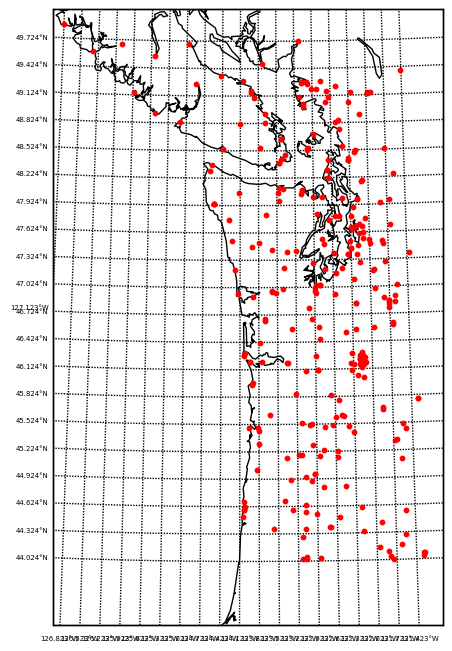

In [7]:
%matplotlib inline
##### Making the basemap
fig, axes = plt.subplots(1,1,figsize=(10,8))
fig.subplots_adjust(wspace=0, hspace=0)

#Raw plot da salvare all images
xl = np.arange(np.amin(df.longitude), np.amax(df.longitude), 0.3) #grid_space is the desired delta/step of the output array
yl = np.arange(np.amin(df.latitude), np.amax(df.latitude), 0.3)
parallels = yl
meridians = xl
levels = np.linspace(-0.005,0.005,100)
   
m = Basemap(ax=axes,width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)

basexx,baseyy=m(longitude,latitude)
m.scatter(basexx, baseyy, 10, marker='o', color='Red', zorder=3)

m.drawcoastlines()
m.drawparallels(parallels,labels=[1,0,0,1],fontsize=5)
m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=5)
m.drawmapboundary(fill_color='white')  




### Period of interest

In [8]:
t = np.arange(datetime.datetime(2010,1,1), datetime.datetime(2023,1,1), datetime.timedelta(days=1)).astype(datetime.datetime)

### Components and Flags

In [9]:
componentsT=['E','N','U'] 
#### Choose components ####
indC=[0,1] #,2
components=list(np.array(componentsT)[indC])
print('You are using these components: ',np.array(componentsT)[indC])
gratsid_flag=True
exp_flag=True


namesT=[]
if gratsid_flag==True and exp_flag==True:
    for c in components:
        namesT.append([c,'DL_'+c,'EMV_'+c,'GrAtSiD_'+c])
else:
    for c in components:
        namesT.append([c,'DL_'+c])
names = [item for sublist in namesT for item in sublist]
names = ['YYMMDD'] + names
print(names)


You are using these components:  ['E' 'N']
['YYMMDD', 'E', 'DL_E', 'EMV_E', 'GrAtSiD_E', 'N', 'DL_N', 'EMV_N', 'GrAtSiD_N']


### Set input_length, Derivative step and componets

In [10]:
input_length=31
to_end=3
position=input_length-to_end
step=1

soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
vel_folder=soln_folder_path+'_vel_'+str(step)+'d'

if not os.path.exists(vel_folder):
    os.makedirs(vel_folder)
    print(vel_folder," created successfully")
    compute_derivative(soln_folder_path,step,names,vel_folder)
    print(vel_folder," Derivative computed successfully")
else:
    print(vel_folder," already exists")

/home/giacomo/Documents/Cascadia/Filtered_31_28_vel_1d  already exists


### Select Stations

In [11]:
list_stations=id_names_txt(vel_folder)
Stations,dft=avaliable_stations_vel(vel_folder,list_stations,t,names)

10%
20%
30%
40%
50%
60%
70%
80%
90%


### Choose which quantity to plot

In [12]:
#### Check intersections between coordinates and txt files
filtered_df = df[df['station'].isin(list_stations)]

what_to_plot='DL' #GrAtSiD,EMV
what_c=[]

quali=[i for i in range(len(names)) if what_to_plot in names[i]]

In [72]:
## Quiver properities
ww = 0.003
hh = 4
qscal = 2e-3

### Make Plot

In [73]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib


fig, ax = plt.subplots(1,1,figsize=(10,8))
fig.subplots_adjust(wspace=0, hspace=0)
m = Basemap(ax=ax,width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
m.drawcoastlines()
m.drawmapboundary(fill_color='white') 

North=[]
Est=[]
Up=[]
Latitude=[]
Longitude=[]

f=0
for f in range(len(Stations[0:1])):

    for k in range(len(Stations[f])):
        station=Stations[f][k][0]
        aa=vel_folder+'/'+str(station)+'.txt'
        
        line_number = Stations[f][k][1]
        with open(aa, 'r') as file:
            for _ in range(line_number - 1):
                file.readline()       
            line = file.readline()
        
        split_line=line.split()
        Lat=float(filtered_df[filtered_df.station==station].latitude)
        Lon=float(filtered_df[filtered_df.station==station].longitude)
        E=split_line[quali[0]]
        N=split_line[quali[1]]
        
        Est.append(E)
        North.append(N)
        Latitude.append(Lat)
        Longitude.append(Lon)
        if len(quali)>2:
            Up.append(split_line[quali[2]])

x,y = m(Longitude,Latitude)
ha_hor = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
ha_hor.remove()
#plt.show()
ha_hor = None

def update(f):
    global ha_hor
    #for f in range(len(Stations[0:10])) :   
    North=[]
    Est=[]
    Up=[]
    Latitude=[]
    Longitude=[]
    
    for i in range(len(Stations[f])):
    
        station=Stations[f][i][0]
        aa=vel_folder+'/'+str(station)+'.txt'
        
        line_number = Stations[f][i][1]
        with open(aa, 'r') as file:
            for _ in range(line_number - 1):
                file.readline()       
            line = file.readline()
        
        split_line=line.split()
        Lat=float(filtered_df[filtered_df.station==station].latitude)
        Lon=float(filtered_df[filtered_df.station==station].longitude)
        E=split_line[quali[0]]
        N=split_line[quali[1]]
        
        Est.append(E)
        North.append(N)
        Latitude.append(Lat)
        Longitude.append(Lon)
        if len(quali)>2:
            Up.append(split_line[quali[2]])
            
    x,y = m(Longitude,Latitude)
    if ha_hor is not None:
        ha_hor.remove()
    
    # Create a new quiver object for each frame
    ha_hor = m.quiver(x, y, np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal, scale_units='inches', color='blue', width=ww, headwidth=hh)

    ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
   
    #line.set_data(x_data[:frame], y_data[:frame])
    #arrow.set_xy([x_data[frame], y_data[frame]])
    return 

#Create the animation
# Set the output file name
output_file = cd+"animation_output_"+str(input_length)+"_"+str(position)+".mp4"  # You can change the file name if needed
writers = animation.writers
writer = writers['ffmpeg']()
ani = FuncAnimation(fig, update, interval=10, frames=range(len(Stations[0:100]) ))
ani.save(output_file, writer=writer, dpi=100)

### Animation with Subplots - vary position and step for computing the derivative 

In [77]:
Positions=[28,29,30]
Steps=[1,4]

In [ ]:
STATIONS_TOT=[]

for ii in range(len(Steps)):
    STATIONS_step=[]
    step=Steps[ii]
    for kk in range(len(Positions)):
        position=Positions[kk]
        soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
        vel_folder=soln_folder_path+'_vel_'+str(step)+'d'
        print('Step: ',str(step),' - Position: ',str(position))
        list_stations=id_names_txt(vel_folder)
        Stations,dft=avaliable_stations_vel(vel_folder,list_stations,t,names)
        STATIONS_step.append(Stations)
    STATIONS_TOT.append(STATIONS_step)

Step:  1  - Position:  28
10%
20%
30%
40%
50%
60%
70%
80%
90%


#### Plot

In [85]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib

fig, axes = plt.subplots(len(Steps),len(Positions),figsize=(10,8))
fig.subplots_adjust(wspace=0, hspace=0)

for ii in range(len(Steps)):
    step=Steps[ii]
    for kk in range(len(Positions)):
        m = Basemap(ax=axes[ii,kk],width=Width,height=Height,projection='lcc',
            resolution='i',lat_1=lat_1,lat_2=lat_2,lat_0=lat_0,lon_0=lon_0)
        STATIONS=STATIONS_TOT[ii][kk]
        
        North=[]
        Est=[]
        Up=[]
        Latitude=[]
        Longitude=[]
        
        f=0
        for k in range(len(STATIONS[f])):
            station=STATIONS[f][k][0]
            aa=vel_folder+'/'+str(station)+'.txt'
            
            line_number = STATIONS[f][k][1]
            with open(aa, 'r') as file:
                for _ in range(line_number - 1):
                    file.readline()       
                line = file.readline()
            
            split_line=line.split()
            Lat=float(filtered_df[filtered_df.station==station].latitude)
            Lon=float(filtered_df[filtered_df.station==station].longitude)
            E=split_line[quali[0]]
            N=split_line[quali[1]]
            
            Est.append(E)
            North.append(N)
            Latitude.append(Lat)
            Longitude.append(Lon)
        x,y = m(Longitude,Latitude)
        ha_hor = m.quiver(np.array(x), np.array(y), np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal,color='blue',width=ww,headwidth=hh)
        ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
        ha_hor.remove()
    
           

IndexError: list index out of range

In [87]:
split_line

[]

In [ ]:

#plt.show()
ha_hor = None

def update(f):
    global ha_hor
    #for f in range(len(Stations[0:10])) :   
    North=[]
    Est=[]
    Up=[]
    Latitude=[]
    Longitude=[]
    
    for i in range(len(Stations[f])):
    
        station=Stations[f][i][0]
        aa=vel_folder+'/'+str(station)+'.txt'
        
        line_number = Stations[f][i][1]
        with open(aa, 'r') as file:
            for _ in range(line_number - 1):
                file.readline()       
            line = file.readline()
        
        split_line=line.split()
        Lat=float(filtered_df[filtered_df.station==station].latitude)
        Lon=float(filtered_df[filtered_df.station==station].longitude)
        E=split_line[quali[0]]
        N=split_line[quali[1]]
        
        Est.append(E)
        North.append(N)
        Latitude.append(Lat)
        Longitude.append(Lon)
        if len(quali)>2:
            Up.append(split_line[quali[2]])
            
    x,y = m(Longitude,Latitude)
    if ha_hor is not None:
        ha_hor.remove()
    
    # Create a new quiver object for each frame
    ha_hor = m.quiver(x, y, np.array(Est).astype('float'), np.array(North).astype('float'), scale=qscal, scale_units='inches', color='blue', width=ww, headwidth=hh)

    ax.set_title('Current day: t = '+ str(t[f].date())+'\n'+'Velocity: '+ str(t[f-step].date())+' - '+str(t[f].date()),fontsize=8) 
   
    #line.set_data(x_data[:frame], y_data[:frame])
    #arrow.set_xy([x_data[frame], y_data[frame]])
    return 

#Create the animation
# Set the output file name
output_file = cd+"animation_output_"+str(input_length)+"_"+str(position)+".mp4"  # You can change the file name if needed
writers = animation.writers
writer = writers['ffmpeg']()
ani = FuncAnimation(fig, update, interval=10, frames=range(len(Stations[0:100]) ))
ani.save(output_file, writer=writer, dpi=100)